In [57]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
import pandas as pd
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from src.features import build_features

COLOR_PALETTE = [
    "#05a298",
    "#0070bc",
    "#d06b6d",
    "#a8e667",
    "#57832e",
    "#56ebd3",
    "#0a4f4e",
    "#9ecbf4",
]

plt.rcParams["figure.figsize"] = (12, 6)
sns.set_theme(style="whitegrid", palette=COLOR_PALETTE)

# Comparacion de Resultados GRD y DEIS

En este cuadernillo se quieren calcular las diferencias entre las bases de egresos hospitalarios GRD y DEIS. Se compararán:

1. Cantidad de egresos hospitalarios
2. Ranking para cada uno de los diagnósticos

Este análisis se realizará a nivel Nacional y a nivel del Hospital del Tórax

In [59]:
# Lee ranking de egresos DEIS
ranking_egresos_nacionales_deis = pl.read_csv(
    "../data/external/ranking_nacional_egresos.csv", encoding="latin-1", separator=";"
).to_pandas()

# Solo deja los estblecimientos publicos en DEIS
ranking_egresos_publicos_deis = ranking_egresos_nacionales_deis.dropna(
    subset="ranking_publicos_n_egresos"
).copy()

# Solo deja los establecimientos GRD que estan en DEIS
ranking_egresos_grd_deis = ranking_egresos_nacionales_deis.dropna(
    subset="ranking_grd_n_egresos"
).copy()

# Obtiene los egresos DEIS del Torax
ranking_egresos_torax_deis = ranking_egresos_nacionales_deis.query(
    "ESTABLECIMIENTO_SALUD == 112103"
).copy()

# Lee ranking de egresos GRD
ranking_egresos_nacionales_grd = pl.read_csv(
    "../data/interim/ranking_nacionales_egresos_grd.csv", separator=";"
).to_pandas()

# Obtiene los egresos GRD del Torax
ranking_egresos_torax_grd = ranking_egresos_nacionales_grd.query("COD_HOSPITAL == 112103").copy()

# Diferencias en cantidad de Hospitales presentes

In [60]:
# Calcula la cantidad de hospitales DEIS, Publicos en DEIS y GRD
cantidad_hospitales_totales_deis = (
    ranking_egresos_nacionales_deis.groupby("ANO_EGRESO")["ESTABLECIMIENTO_SALUD"]
    .nunique()
    .to_frame()
)

cantidad_hospitales_publicos_deis = (
    ranking_egresos_publicos_deis.groupby("ANO_EGRESO")["ESTABLECIMIENTO_SALUD"]
    .nunique()
    .to_frame()
)

cantidad_hospitales_grd = (
    ranking_egresos_nacionales_grd.groupby("ANIO_EGRESO")["COD_HOSPITAL"].nunique().to_frame()
)

In [61]:
# Une los resultados de cantidad de hospitales
comparacion_cantidad_de_hospitales = pd.concat(
    [cantidad_hospitales_totales_deis, cantidad_hospitales_publicos_deis, cantidad_hospitales_grd],
    axis=1,
).dropna()

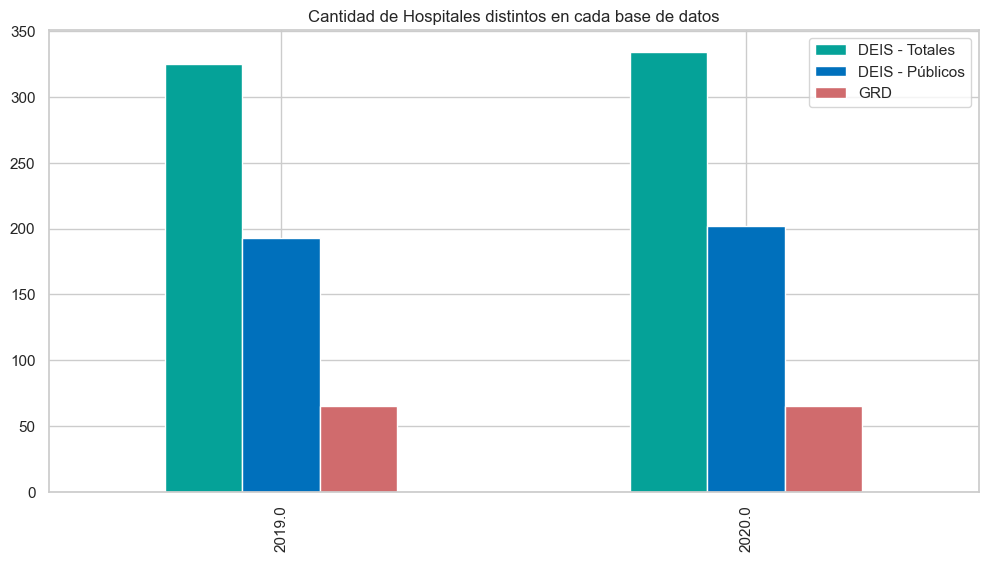

In [62]:
# Grafica comparacion de cantidad de hospitales
axis = comparacion_cantidad_de_hospitales.plot(kind="bar")
axis.legend(labels=["DEIS - Totales", "DEIS - Públicos", "GRD"])
plt.title("Cantidad de Hospitales distintos en cada base de datos")
plt.savefig("../reports/cantidad_recintos_hospitalarios.png")
plt.show()

# Diferencias en cantidad de Egresos Hospitalarios

Observando que DEIS Público contiene una mayor cantidad de recntos hospitalarios que GRD, es esperable que el primer contenga mayor cantidad de egresos hospitalarios. Debido a esto, sólamente se compararán los recintos hospitalarios que estén en ambas bases de datos.

In [63]:
# Calcula egresos para cada base de datos
egresos_nacionales_deis = ranking_egresos_nacionales_deis.groupby("ANO_EGRESO")["n_egresos"].sum()
egresos_publicos_deis = ranking_egresos_publicos_deis.groupby("ANO_EGRESO")["n_egresos"].sum()
egresos_grd_deis = ranking_egresos_grd_deis.groupby("ANO_EGRESO")["n_egresos"].sum()
egresos_grd = ranking_egresos_nacionales_grd.groupby("ANIO_EGRESO")["n_egresos"].sum()

# Une el calculo de egresos
comparacion_egresos = pd.concat(
    [egresos_nacionales_deis, egresos_publicos_deis, egresos_grd_deis, egresos_grd], axis=1
).dropna()

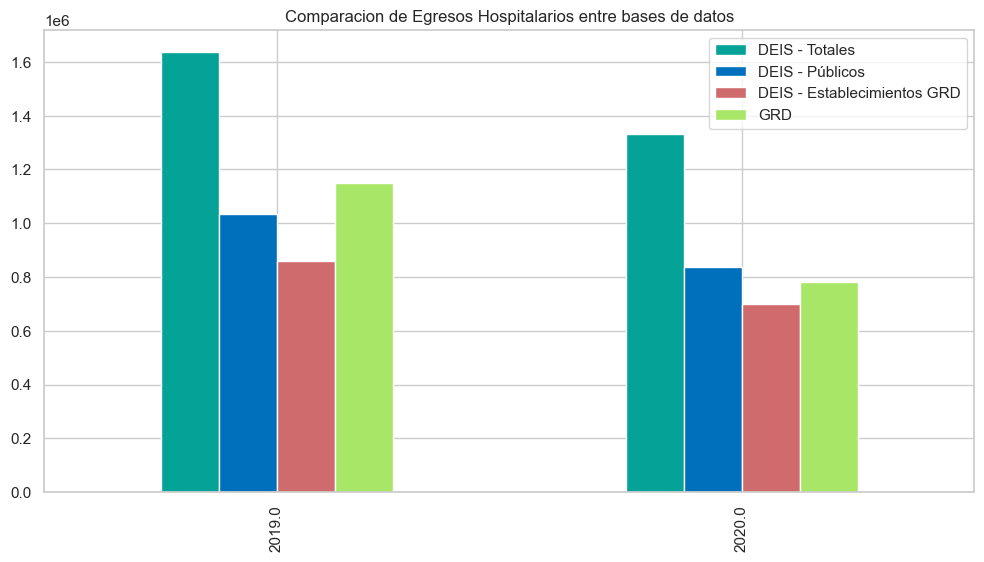

In [64]:
axis = comparacion_egresos.plot(kind="bar")
axis.legend(["DEIS - Totales", "DEIS - Públicos", "DEIS - Establecimientos GRD", "GRD"])
plt.title("Comparacion de Egresos Hospitalarios entre bases de datos")
plt.savefig("../reports/egresos_hospitalarios_deis_grd.png")
plt.show()

Una vez analizada la diferencia de egresos entre las distintas bases de datos, se pueden destacar los siguientes puntos:

1. DEIS registra la mayor cantidad de egresos, ya que incluye tanto los egresos nacionales de recintos públicos como privados.

2. Al comparar los recintos públicos de DEIS (193) con los de GRD (65), se identifican diferentes tendencias en la cantidad de egresos hospitalarios. En 2019, la base de datos GRD muestra un mayor número de egresos a pesar de contar con un número significativamente menor de recintos hospitalarios. Esto indica que los hospitales adscritos a GRD concentran una gran parte de los egresos hospitalarios del sistema público. Sin embargo, en 2020, se observa que GRD tiene una cantidad ligeramente menor de egresos en comparación con los recintos públicos en DEIS.

3. Al comparar los egresos de los recintos GRD registrados en DEIS con los egresos de GRD, se observa que DEIS reporta una menor cantidad de egresos, especialmente marcado en 2019.

Finalmente, se quiere ver el comportamiento de los egresos hospitalarios para el Instituto Nacional del Tórax

In [65]:
# Calcula la cantidad de egresos del hospital seleccionado
egresos_torax_deis = ranking_egresos_torax_deis.groupby("ANO_EGRESO")["n_egresos"].sum()
egresos_torax_grd = ranking_egresos_torax_grd.groupby("ANIO_EGRESO")["n_egresos"].sum()

comparacion_egresos_torax = pd.concat([egresos_torax_deis, egresos_torax_grd], axis=1).dropna()

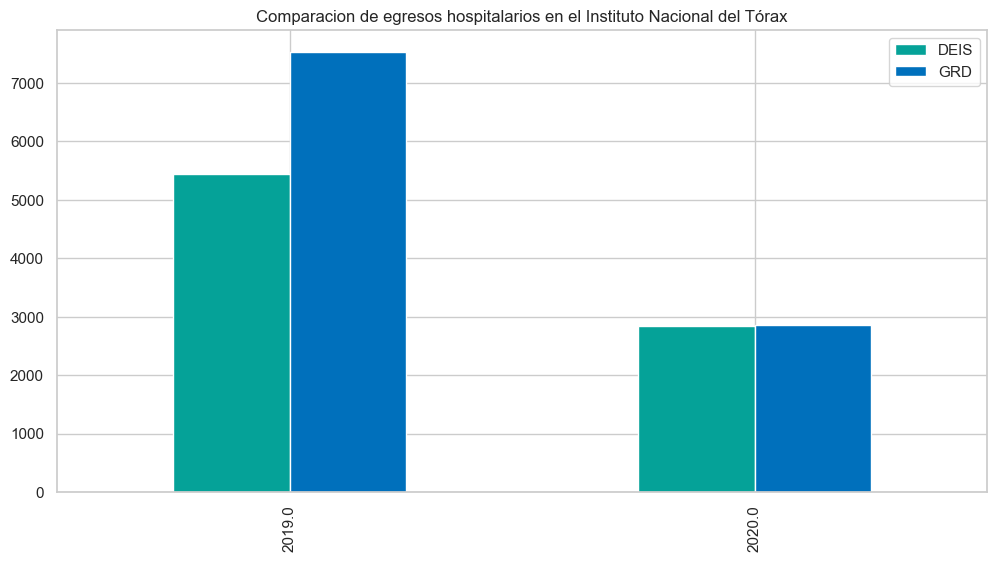

In [66]:
axis = comparacion_egresos_torax.plot(kind="bar")
axis.legend(["DEIS", "GRD"])
plt.title("Comparacion de egresos hospitalarios en el Instituto Nacional del Tórax")
plt.savefig("../reports/egresos_hospitalarios_deis_grd_int.png")
plt.show()

1. En 2019, la base de datos GRD muestra una mayor cantidad de egresos (~7200) en comparación con la base de datos DEIS. Esto se debe a que el INT incluyó las Cirugías Mayores Ambulatorias (CMA) como parte de los egresos hospitalarios, incrementando así el número total de egresos registrados.

2. En 2020, ambas bases de datos presentan una cantidad similar de egresos hospitalarios, con GRD mostrando una leve ventaja en la cantidad de egresos.

---

## Comparacion de Posiciones en Rankings por Patologia 

In [67]:
# Define columnas a analizar entre ambas bases
COLUMNAS_A_SELECCIONAR = [
    "ANIO_EGRESO",
    "COD_HOSPITAL",
    "DIAGNOSTICO1",
    "Capítulo",
    "Sección",
    "Categoría",
    "Descripción",
    "GLOSA_ESTABLECIMIENTO_SALUD",
    "n_egresos_GRD",
    "n_egresos_DEIS",
    "ranking_egresos",
    "ranking_grd_n_egresos",
    "dias_estada_totales_GRD",
    "dias_estada_totales_DEIS",
    "ranking_nacionales_n_egresos",
    "ranking_publicos_n_egresos",
]

# Une ambas bases de datos segun el anio, hospital y diagnostico principal
comparacion_grd_deis_pais = (
    ranking_egresos_nacionales_grd.merge(
        ranking_egresos_nacionales_deis,
        left_on=["ANIO_EGRESO", "COD_HOSPITAL", "DIAGNOSTICO1"],
        right_on=["ANO_EGRESO", "ESTABLECIMIENTO_SALUD", "DIAG1"],
        how="inner",
        suffixes=("_GRD", "_DEIS"),
    )[COLUMNAS_A_SELECCIONAR]
)

# Obtiene comparacion de egresos solamente para el Torax
comparacion_grd_deis_torax = comparacion_grd_deis_pais.query("COD_HOSPITAL == 112103").copy()

In [68]:
RELEVANT_DIAGNOSES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I051",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

DIFERENCIAS_A_CALCULAR = [
    ("ranking_egresos", "ranking_grd_n_egresos"),
]

COLUMNA_RANKINGS = "ranking_egresos_ranking_grd_n_egresos_difference"

# Calcula diferencias entre egresos y rankings a nivel pais y Torax
comparacion_grd_deis_pais = build_features.calculate_and_add_difference(
    comparacion_grd_deis_pais, DIFERENCIAS_A_CALCULAR
)

comparacion_grd_deis_torax = build_features.calculate_and_add_difference(
    comparacion_grd_deis_torax, DIFERENCIAS_A_CALCULAR
)

In [69]:
# Obtiene el promedio de las diferencias de rankings
diferencia_ranking_pais = comparacion_grd_deis_pais[COLUMNA_RANKINGS]
diferencia_ranking_torax = comparacion_grd_deis_torax[COLUMNA_RANKINGS].reset_index(drop=True)
diferencia_ranking_torax_45_relevantes = comparacion_grd_deis_torax.query(
    "DIAGNOSTICO1.isin(@RELEVANT_DIAGNOSES)"
)[COLUMNA_RANKINGS].reset_index(drop=True)

# Obtiene el promedio de las diferencias de rankings
print(f"> {diferencia_ranking_pais.mean()=:.2f} posiciones")
print(f"> {diferencia_ranking_torax.mean()=:.2f} posiciones")
print(f"> {diferencia_ranking_torax_45_relevantes.mean()=:.2f} posiciones")

# Une las diferencias para graficarlas
comparacion_rankings_pais_torax = pd.DataFrame(
    {
        "diferencias_pais": diferencia_ranking_pais,
        "diferencias_torax": diferencia_ranking_torax,
        "diferencias_torax_45_relevantes": diferencia_ranking_torax_45_relevantes,
    }
)

> diferencia_ranking_pais.mean()=6.14 posiciones
> diferencia_ranking_torax.mean()=4.46 posiciones
> diferencia_ranking_torax_45_relevantes.mean()=0.66 posiciones


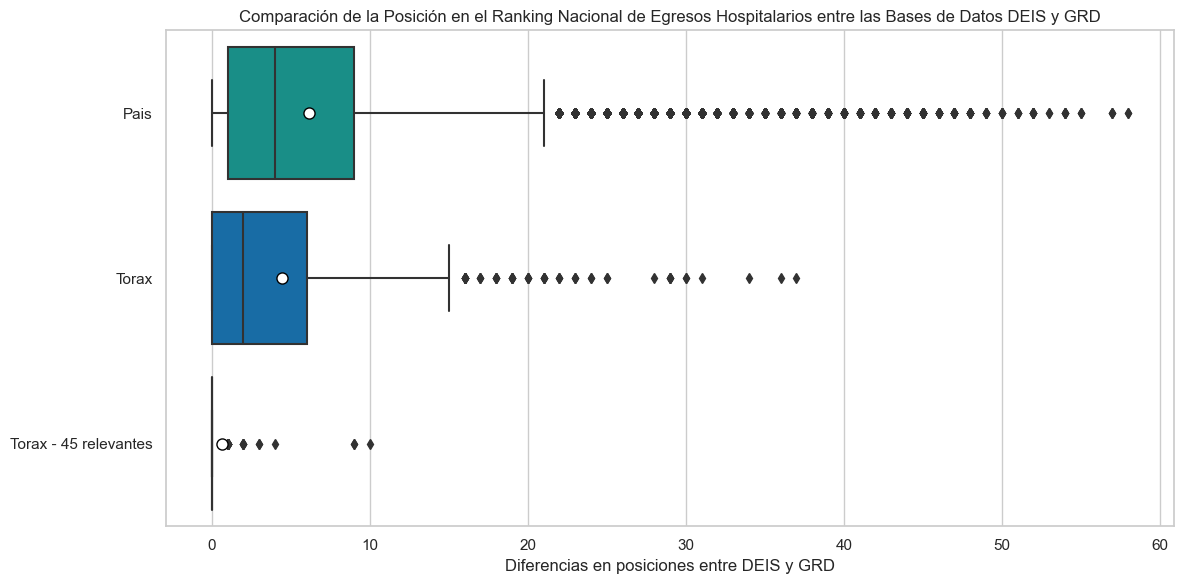

In [70]:
axis = sns.boxplot(
    comparacion_rankings_pais_torax,
    orient="h",
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "8",
    },
)

plt.yticks([0, 1, 2], ["Pais", "Torax", "Torax - 45 relevantes"])
plt.title("Comparación de la Posición en el Ranking Nacional de Egresos Hospitalarios entre las "
          "Bases de Datos DEIS y GRD")
plt.xlabel("Diferencias en posiciones entre DEIS y GRD")
plt.tight_layout()
plt.savefig("../reports/comparacion_posiciones_deis_grd.png", dpi=400)
plt.show()